# Capstone 3: Customer Segmentation pt. 2

## Modeling

In this notebook, we will try out several different models (using different algorithms and subsets of our data) in an attempt to find the best method of segmentation. We'll then go back to our full customer dataset to begin interpreting the results, defining the unique characteristics of each segment.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Read in our model-ready data, which is the log values of the customer DataFrame.
df = pd.read_csv("log_customers.csv", index_col=0)
df

,max_price,total_value,frequency,avg_items,recency,avg_order_time,region_Europe,region_Other
CustomerID,,,,,,,,
12346.0,6.693487,6.019257,1.584963,3.058894,8.348728,7.335390,0,0
12347.0,3.672425,12.459770,3.000000,4.982994,1.584963,5.857981,1,0
12348.0,0.536053,10.695576,2.321928,3.201634,6.247928,6.515700,1,0
12349.0,5.320124,11.835474,1.584963,5.841302,4.247928,8.159871,1,0
12350.0,1.560715,8.201634,0.000000,4.000000,8.280771,0.000000,1,0
...,...,...,...,...,...,...,...,...
18283.0,3.995485,11.415055,4.459432,5.483083,2.000000,4.985045,0,0
18284.0,2.087463,8.685380,0.000000,4.754888,8.754888,0.000000,0,0
18285.0,3.902074,8.558421,0.000000,3.459432,9.368506,0.000000,0,0


In [3]:
df.describe()

,max_price,total_value,frequency,avg_items,recency,avg_order_time,region_Europe,region_Other
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,3.598121,9.812568,1.734090,3.979021,6.386918,4.406934,0.078582,0.010615
std,1.234727,1.998435,1.481163,1.308923,2.301949,3.003299,0.269109,0.102488
min,-2.556393,1.536053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.087463,8.398701,0.000000,3.321928,4.700440,0.000000,0.000000,0.000000
50%,3.672425,9.756840,1.584963,4.129283,6.584963,5.554589,0.000000,0.000000
75%,4.083213,11.124050,2.807355,4.813781,8.569856,6.681871,0.000000,0.000000
max,10.867171,19.206611,8.554589,8.227404,9.529431,9.481799,1.000000,1.000000


### ***K-Means***
First, a K-Means approach using all features in the dataset. We'll look at inertia (sum of squared distance to cluster center) as well as silhouette score to find the best number of clusters, k.

In [4]:
# Set range of possible k
ks = range(2, 11)

# Lists to collect relevant scores
inertias = []
sil = []

# loop over values of k, instantiate a model, and append the scores to our lists
for k in ks:
    model = KMeans(n_clusters=k, init='random', random_state=36)
    model.fit(df)
    inertias.append(model.inertia_)
    sil.append(silhouette_score(df, model.labels_))

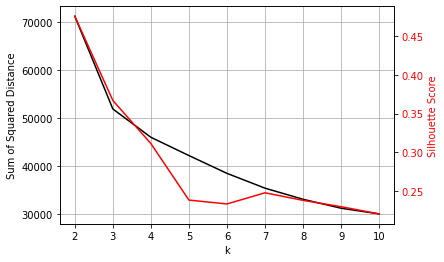

In [5]:
# Plot Sum-of-squares for each k, looking for the elbow value
fig, ax1 = plt.subplots()
plt.grid()

ax1.plot(ks, inertias, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylabel('Sum of Squared Distance', color='k')
ax1.set_xlabel('k')

# Plot silhouette score for each k, looking for a reasonably high score
ax2 = ax1.twinx()
ax2.plot(ks, sil, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Silhouette Score', color='r')

plt.show()

The elbows in the inertia graph seems to indicate 3 or 4 as the ideal number of clusters. The silhouette score is best at 2 segments, but is still decent at 3 or 4 segments. Let's take a closer look at the outcomes for 3 and 4 clusters. We can get a sense of how intuitive the clustering is by using PCA to reduce our data to 2D and graphing the result, with cluster labels separated by color.

In [6]:
# Choose colors for up to 6 clusters, plus -1
colors = ['darkcyan', 'black', 'gold', 'darkmagenta', 'coral', 'silver', 'lime']

Inertia: 51900.54418674276
Silhouette Score: 0.36695162448063134


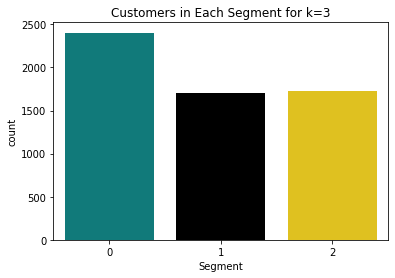

In [7]:
# Fit the model with k=3
km3_model = KMeans(n_clusters=3, random_state=36)
km3_model.fit(df)

# Get cluster labels, and print inertia and silhouette score
km3_labels = pd.Series(km3_model.labels_)
km3_sil = silhouette_score(df, km3_labels)
print("Inertia: {}\nSilhouette Score: {}".format(km3_model.inertia_, km3_sil))

# Graph a countplot of customers in each segment
sns.countplot(x=km3_labels, palette=colors[:3])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=3');

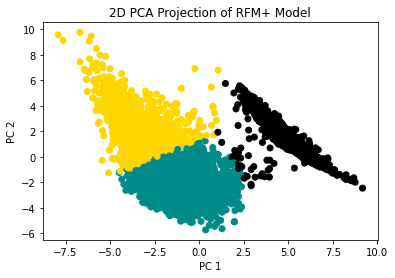

In [8]:
# Use PCA to reduce data to 2D for cluster visualization
pca = PCA(n_components=2)
pca.fit(df)
components = pca.transform(df)

# Set first two principal components for x and y values
pcax = components[:,0]
pcay = components[:,1]

# Scatterplot of first two principal components colored by segment
colorlist = [colors[s] for s in km3_labels]
plt.scatter(pcax, pcay, c=colorlist)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D PCA Projection of RFM+ Model');

Inertia: 46008.13041602271
Silhouette Score: 0.31126550481548465


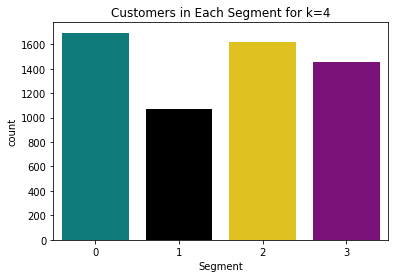

In [9]:
# Try another model with k=4
km4_model = KMeans(n_clusters=4, random_state=36)
km4_model.fit(df)

km4_labels = pd.Series(km4_model.labels_)
km4_sil = silhouette_score(df, km4_labels)
print("Inertia: {}\nSilhouette Score: {}".format(km4_model.inertia_, km4_sil))

sns.countplot(x=km4_labels, palette=colors[:4])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=4');

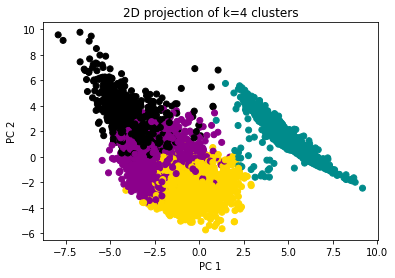

In [10]:
colorlist = [colors[s] for s in km4_labels]
plt.scatter(pcax, pcay, c=colorlist)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D projection of k=4 clusters');

In our 2D scatterplot, there does appear to be a clearly identifiable long, thin cluster to the right (representing about 1600 customers), with the rest in a larger teardrop-shaped mass to the left. Based on the EDA performed in the previous notebook for this project, I suspect the thin cluster is probably associated with customers with avg_order_time of 0.

Both models identify the thin cluster, along with a few extra points that appear to be closer to the teardrop (remember this 2D plot is an oversimplified version of the 8D data), then separate the teardrop into 2 or 3 additional clusters. Although the 4-cluster model segments are less well-defined, it may still be helpful to keep this teardrop middle-cluster (the purple group in the scatterplot directly above) when we move on to interpreting the underlying customer segments. At that time, we can decide whether there is a benefit to the 4 groups, or if 3 groups is sufficient.

However, we still need to try out a few more models before we settle on the best segmentation. Next, let's continue using K-Means but with a subset of our data. A traditional RFM analysis would contain just these three features - Recency, Frequency, and Monetary Value.

In [11]:
# df of only RFM features
rfm = df[['recency', 'frequency', 'total_value']]

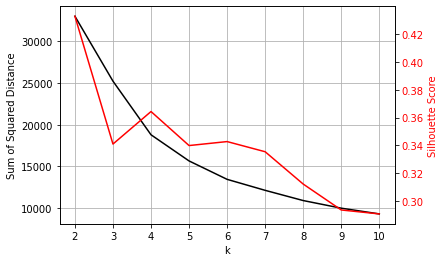

In [12]:
# Repeat methods to find optimal k value
inertias = []
sil = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=36)
    model.fit(rfm)
    inertias.append(model.inertia_)
    sil.append(silhouette_score(rfm, model.labels_))
    
# Plot inertia and sil scores
fig, ax1 = plt.subplots()
plt.grid()

ax1.plot(ks, inertias, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylabel('Sum of Squared Distance', color='k')
ax1.set_xlabel('k')

ax2 = ax1.twinx()
ax2.plot(ks, sil, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Silhouette Score', color='r')

plt.show()

Inertia: 18795.137659256026
Silhouette Score: 0.36434038762683657


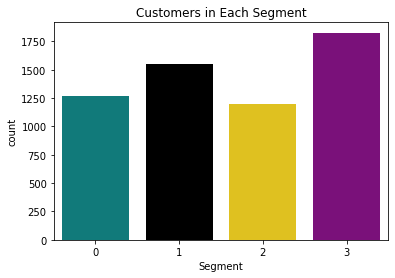

In [13]:
# Optimal k=4. Repeat method to visualize cluster size and 2D scatter:

# Fit model to rfm, get labels, print scores
rfm_km_model = KMeans(n_clusters=4, random_state=36)
rfm_km_model.fit(rfm)
rfm_km_labels = pd.Series(rfm_km_model.labels_)
rfm_km_sil = silhouette_score(rfm, rfm_km_labels)

print("Inertia: {}\nSilhouette Score: {}".format(rfm_km_model.inertia_, rfm_km_sil))

sns.countplot(x=rfm_km_labels, palette=colors[:4])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

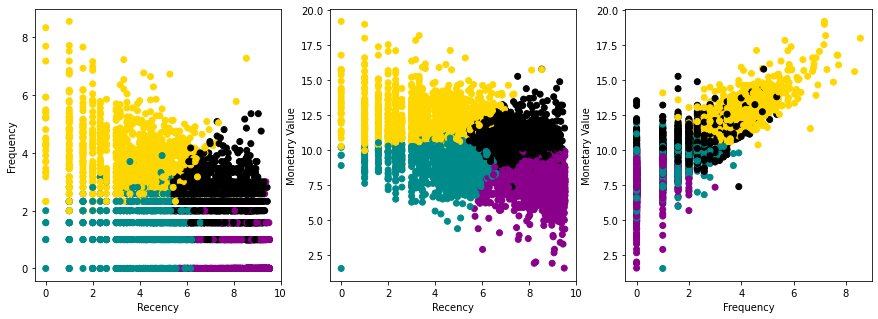

In [14]:
# Because the data is only 3D, we don't need to do dimension reduction, 
# we can simply plot three graphs--one for each feature pair
# Scatterplot of clusters
colorlist = [colors[s] for s in rfm_km_labels]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(rfm.recency, rfm.frequency, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(rfm.recency, rfm.total_value, c=colorlist)
plt.xlabel('Recency')
plt.ylabel('Monetary Value')

plt.subplot(1, 3, 3)
plt.scatter(rfm.frequency, rfm.total_value, c=colorlist)
plt.xlabel('Frequency')
plt.ylabel('Monetary Value');

In these graphs, there is no obvious (to the eye) clustering of the data, though there are some distinct lines of points in the lower parts of the axes that are an artifact of the logarithmic scales. Still, this model achieved a good silhouette score, nearly as high as the 3-cluster K-Means model above.

The benefit of straight RFM analysis is the results will be easy to interpret:
- the <font color='darkcyan'>**teal**</font> segment above has low recency, low frequency, and low monetary value - these are new/growing customers; 
- the <font color='gold'>**yellow**</font> segment has low recency, high frequency, and high value - these are the current loyal customers;
- the **black** group are the high-value lapsed customers we want to get back;
- and the <font color='darkmagenta'>**purple**</font> group are the older customers who only bought once or a few times, then quickly churned.

This analysis is helpful and can lead us to actionable conclusions. However, is there any benefit to including the other features we have? Remember the long, thin cluster in the full dataset - does that segment add anything to our understanding of our customers? One way to check is to use the labels from one model on the scatterplot of the other dataset, and see if the clusters match.

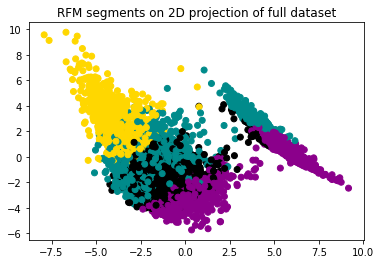

In [15]:
# with the 'colorlist' set to rfm segment labels, let's see how it looks on the PCA of the full dataset.
colorlist = [colors[s] for s in rfm_km_labels]
plt.scatter(pcax, pcay, c=colorlist)
plt.title('RFM segments on 2D projection of full dataset');

The RFM model splits the thin cluster to the right, primarily between the new customers and quick-churn customers. If the thin cluster represents customers with 0 or low avg_order_time as suspected, this view of RFM segments makes sense - both of these groups would include many customers with low frequency and order time. 

The question we need to answer is what, if anything, is the difference between the teal/purple group in the thin cluster and the rest of the teal/purple group in the teardrop? We'd have to do more in-depth exploration of the labels to say for sure. If there is a meaningful difference, that suggests we should actually be looking for at least 5 or 6 distinct clusters in the full dataset.

Let's move on to some different clustering models to see if we can capture these differences better before answering that question. For now, we'll keep comparing silhouette scores for the models. But, choosing a final model that tells a convincing story may prioritize meaningful segments over well-defined clusters.

### ***Agglomerative Clustering***

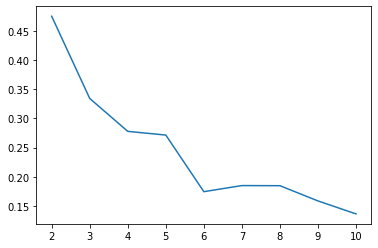

In [16]:
# Compile and plot list of silhouette scores for range of k values
sil = []
for k in ks:
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    labels = model.fit(df).labels_
    sil.append(silhouette_score(df, labels))

plt.plot(ks, sil)

Silhouette Score:  0.33438689040305974


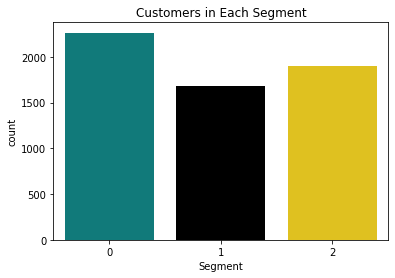

In [17]:
# We'll use k=3 and compare to the K-Means model
ac3_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
ac3_model.fit(df)
ac3_labels = pd.Series(ac3_model.labels_)
ac3_sil = silhouette_score(df, ac3_labels)

print("Silhouette Score: ",ac3_sil)

sns.countplot(x=ac3_labels, palette=colors[:3])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

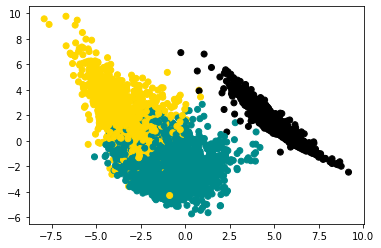

In [18]:
# Plot the 2D PCA projection with new labels
colorlist = [colors[s] for s in ac3_labels]
plt.scatter(pcax, pcay, c=colorlist)

We can see slightly different results for the Agglomerative Clustering model, compared with the K-Means model for k=3. Segment 2 (yellow) is a bit larger in this model, and the division between yellow and teal is less obvious in this 2D projection. The silhouette score for the K-Means model was higher, so it is perhaps a better representation of the data.

### ***Spectral Clustering & DBSCAN***

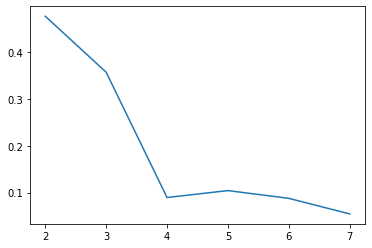

In [19]:
# Limit the range of k to save time, then plot silhouette scores for each k
sc_ks=range(2,8)
sil = []
for k in sc_ks:
    model = SpectralClustering(n_clusters=k)
    model.fit(df)
    labels = model.labels_
    sil.append(silhouette_score(df, labels))

plt.plot(sc_ks, sil)

Silhouette Score:  0.3568811465938454


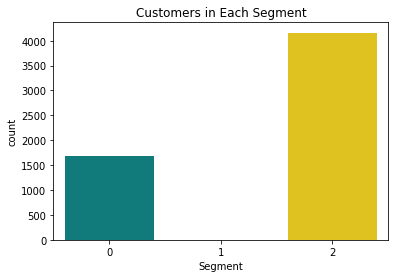

In [20]:
# score is sufficiently high at k=3
sc_model= SpectralClustering(n_clusters=3)
sc_segments = pd.Series(sc_model.fit(df).labels_)

print("Silhouette Score: ",silhouette_score(df, sc_segments))

sns.countplot(x=sc_segments, palette=colors[:3])
plt.xlabel('Segment')
plt.title('Customers in Each Segment');

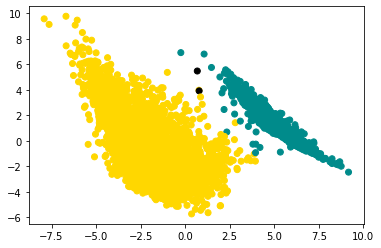

In [21]:
# Looks like segment 1 has very few points, this might not be the best model. Let's visualize the clusters
colorlist = [colors[s] for s in sc_segments]
plt.scatter(pcax, pcay, c=colorlist)

In [22]:
# set a range of window sizes for DBSCAN, and see the results for min_samples=2
windows = range(1, 6)
k_dict = {}
sil_scores = {}
for w in windows:
    model = DBSCAN(eps=w, metric='euclidean', min_samples=2)
    model.fit(df)
    labels = model.labels_
    n_clusters = len(set(model.labels_))
    k_dict[w] = n_clusters
    try:
        sil_score = round(silhouette_score(df, labels), 3)
    except ValueError:
        sil_score = 'N/A'
    sil_scores[w] = sil_score

for w in sil_scores:
    print('Neighborhood size {}: {} clusters, silhouette score = {}'.format(round(w,2), k_dict[w], sil_scores[w]))

Neighborhood size 1: 173 clusters, silhouette score = -0.469
Neighborhood size 2: 6 clusters, silhouette score = 0.064
Neighborhood size 3: 4 clusters, silhouette score = 0.106
Neighborhood size 4: 2 clusters, silhouette score = 0.466
Neighborhood size 5: 2 clusters, silhouette score = 0.466


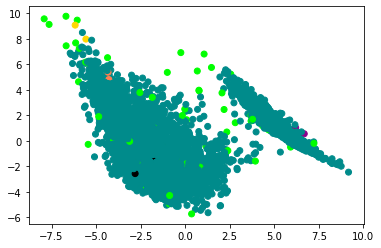

In [23]:
# Note: I tried a range of min_samples and other hyperparameters, without luck to tune a more useful model
# Visualize the clusters (bright green = not assigned to a cluster)
dbs_model = DBSCAN(eps=2, metric='euclidean', min_samples=2)
dbs_model.fit(df)
dbs_segments = pd.Series(dbs_model.labels_)

colorlist = [colors[s] for s in dbs_segments]
plt.scatter(pcax, pcay, c=colorlist)

Spectral Clustering and DBSCAN appear to be inappropriate for the data, which perhaps does not vary much in density.

So, we've narrowed down our models to K-Means or Agglomerative, and should decide whether the extra columns in our dataset would be useful to make business decisions. Let's make sure to run all options and look at them in one place before deciding.

In [24]:
# Fit some alternative models and save their resulting scores
km5_model = KMeans(n_clusters=5, random_state=36)
km5_model.fit(df)
km5_labels = pd.Series(km5_model.labels_)
km5_sil = silhouette_score(df, km5_labels)

ac4_model = AgglomerativeClustering(n_clusters=4, linkage='ward')
ac4_model.fit(df)
ac4_labels = pd.Series(ac4_model.labels_)
ac4_sil = silhouette_score(df, ac4_labels)

ac5_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
ac5_model.fit(df)
ac5_labels = pd.Series(ac5_model.labels_)
ac5_sil = silhouette_score(df, ac5_labels)

rfm_ac_model = AgglomerativeClustering(n_clusters=4)
rfm_ac_model.fit(rfm)
rfm_ac_labels = pd.Series(rfm_ac_model.labels_)
rfm_ac_sil = silhouette_score(rfm, rfm_ac_labels)

In [25]:
# Create a DataFrame for easy reference to compare all models so far
models_df = pd.DataFrame({"model_var":['km3_model', 'km4_model', 'km5_model', 'rfm_km_model', 'ac3_model', 'ac4_model', 'ac5_model', 'rfm_ac_model'],
                          "model_type":['kmeans', 'kmeans', 'kmeans', 'kmeans', 'agglomerative', 'agglomerative', 'agglomerative', 'agglomerative'], 
                          "n_clusters":[3, 4, 5, 4, 3, 4, 5, 4], 
                          "datasource":['df', 'df', 'df', 'rfm', 'df', 'df', 'df', 'rfm'], 
                          "sil_score":[km3_sil, km4_sil, km5_sil, rfm_km_sil, ac3_sil, ac4_sil, ac5_sil, rfm_ac_sil]})
models_df.sort_values('sil_score', ascending=False)

,model_var,model_type,n_clusters,datasource,sil_score
0,km3_model,kmeans,3,df,0.366952
3,rfm_km_model,kmeans,4,rfm,0.364340
4,ac3_model,agglomerative,3,df,0.334387
1,km4_model,kmeans,4,df,0.311266
7,rfm_ac_model,agglomerative,4,rfm,0.297953
5,ac4_model,agglomerative,4,df,0.277886
6,ac5_model,agglomerative,5,df,0.271505
2,km5_model,kmeans,5,df,0.237810


Based on silhouette score alone, a 3-cluster solution, using K-Means clustering, is the best grouping of the data. We'll be sure to save that interpretation as one option for presentation.

However, I think we still ought to consider a model that identifies more segments. The RFM-only model produced the next best score with 4 clusters. But, as mentioned above, a 5- or 6-cluster grouping might be able to tell us more about the importance of the thin cluster found in the full dataset.

Let's try one more model. This time, I'll be using the RFM subset of data, but add the avg_order_time feature, which I believe is the primary cause of the division we see in the full dataset. Hopefully, by adding this column to the model we can identify a greater number of segments, while maintaining a higher silhouette score for the grouping, and separating the thin cluster from the rest of the data.

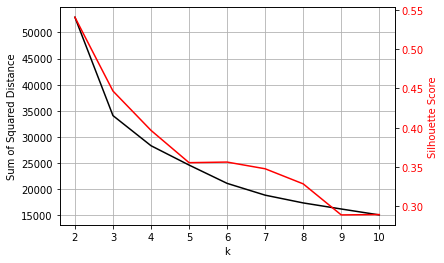

In [26]:
# Add Avg Order Time column to rfm
rfmo = df[['recency', 'frequency', 'total_value', 'avg_order_time']]

# Repeat methods to find optimal k value
inertias = []
sil = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=36)
    model.fit(rfmo)
    inertias.append(model.inertia_)
    sil.append(silhouette_score(rfmo, model.labels_))
    
# Plot inertia and sil scores
fig, ax1 = plt.subplots()
plt.grid()

ax1.plot(ks, inertias, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylabel('Sum of Squared Distance', color='k')
ax1.set_xlabel('k')

ax2 = ax1.twinx()
ax2.plot(ks, sil, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Silhouette Score', color='r')

plt.show()

Though 3 clusters may be the "best" clustering based on the SS elbow, we can still get a high silhouette score with 6 clusters. Let's see the results.

Inertia: 21059.0079203381
Silhouette Score: 0.3559362748834457


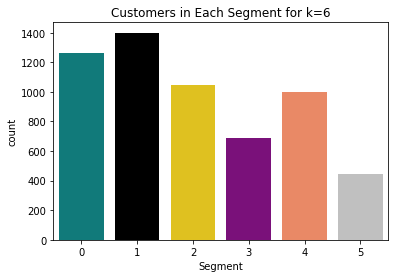

In [27]:
# Fit model to rfm, get labels, print scores
rfmo_model = KMeans(n_clusters=6, random_state=36)
rfmo_model.fit(rfmo)
rfmo_labels = pd.Series(rfmo_model.labels_)
rfmo_sil = silhouette_score(rfmo, rfmo_labels)

print("Inertia: {}\nSilhouette Score: {}".format(rfmo_model.inertia_, rfmo_sil))

sns.countplot(x=rfmo_labels, palette=colors[:6])
plt.xlabel('Segment')
plt.title('Customers in Each Segment for k=6');

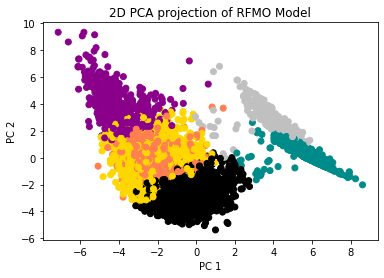

In [28]:
# Use PCA to reduce RFMO data to 2D for cluster visualization
pca = PCA(n_components=2)
pca.fit(rfmo)
rfmo_components = pca.transform(rfmo)

# Set first two principal components for x and y values
rfmo_pcax = rfmo_components[:,0]
rfmo_pcay = rfmo_components[:,1]

# Scatterplot of first two principal components colored by segment
colorlist = [colors[s] for s in rfmo_labels]
plt.scatter(rfmo_pcax, rfmo_pcay, c=colorlist)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('2D PCA projection of RFMO Model');

This model splits the thin cluster into two groups (silver and teal), and the teardrop into 4 groups, yet it has a silhouette score of 0.356, which is not much lower than our top two models. For thoroughness, let's add this model to our models_df.

In [29]:
# Append RFMO model to reference DataFrame
models_df.loc[len(models_df)] = ['rmfo_model', 'kmeans', 6, 'rmfo', rfmo_sil]
models_df.sort_values('sil_score', ascending=False, inplace=True)
models_df

,model_var,model_type,n_clusters,datasource,sil_score
0,km3_model,kmeans,3,df,0.366952
3,rfm_km_model,kmeans,4,rfm,0.364340
8,rmfo_model,kmeans,6,rmfo,0.355936
4,ac3_model,agglomerative,3,df,0.334387
1,km4_model,kmeans,4,df,0.311266
7,rfm_ac_model,agglomerative,4,rfm,0.297953
5,ac4_model,agglomerative,4,df,0.277886
6,ac5_model,agglomerative,5,df,0.271505
2,km5_model,kmeans,5,df,0.237810


Now, we have narrowed down our model options to 3 decent models (all using K-Means) applied to different sets of data. To summarize, they are:
1. A 3-cluster model using all columns
2. A 4-cluster model using RFM columns only
3. A 6-cluster model using RFM columns + Average Order Time

We can keep all these models for presentation to the company, and let marketing staff decide which may be best to describe our customers and develop a comprehensive strategy based on the results. In order to help them make that decision, we need to get a better sense of the differences between the segments. Let's compare the segments in each model on all columns.

### 3-Cluster Model

In [30]:
# copy df and add column for km3 model labels
labeled_df = df
labeled_df['km3'] = km3_labels.values

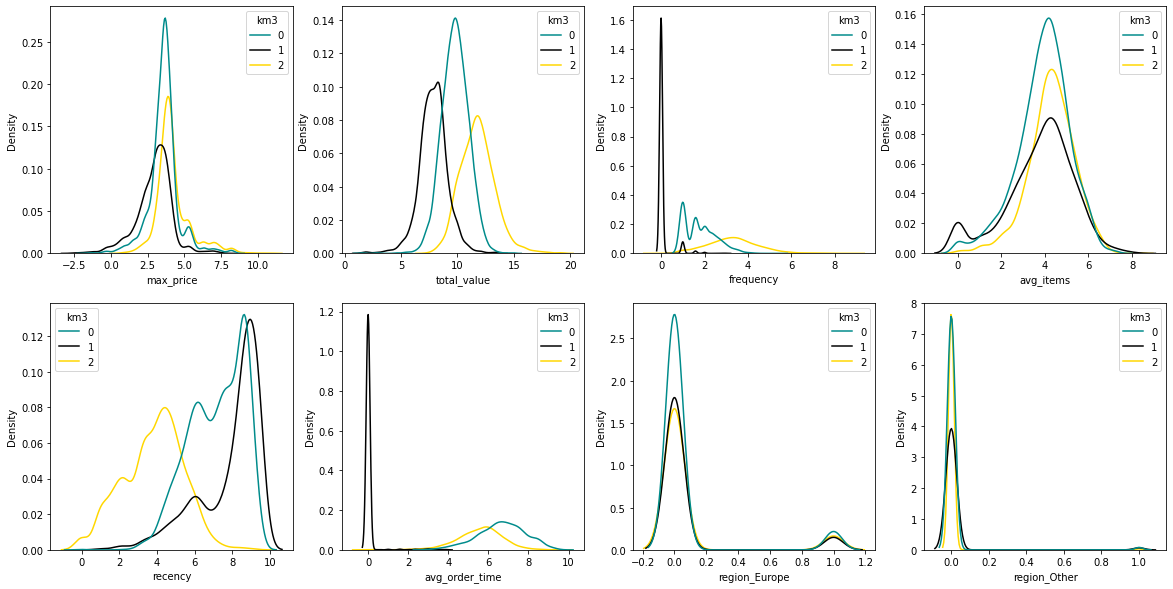

In [31]:
# Plot distributions for each segment in each column
plt.figure(figsize=(20, 10))
n=1
for col in df.columns[:8]:
    plt.subplot(2, 4, n)
    sns.kdeplot(data=labeled_df, x=col, hue='km3', palette=colors[:3])
    n=n+1

As suspected, we can see that segment 1, the black cluster which makes up the thin cluster we saw in the PCA scatterplot, represents customers with 0 or low average order time. In other words, most customers in this group have only made 1 order (or multiple orders over one day/a few days). We can also see from these kde plots that customers in segment 1 tend to have a low total value, and higher recency, meaning most are old orders. Though the max price and average number of items covers a wider range like the other segments, there are more customers in this segment on the lower end.

Segment 0 (teal) has the next highest total value. Most customers in this segment have made 2-5 orders in this period, though they have the longest average time between orders, and many also have high recency, like segment 1.

Segment 2 (yellow) is marked by lower recency than the other clusters, and a higher total value. These customers are more likely to have made many orders over this period, including recent purchases, indicating active, loyal customers. Compared with segment 1, they are also willing to purchase more expensive items.

### 4-Cluster Model

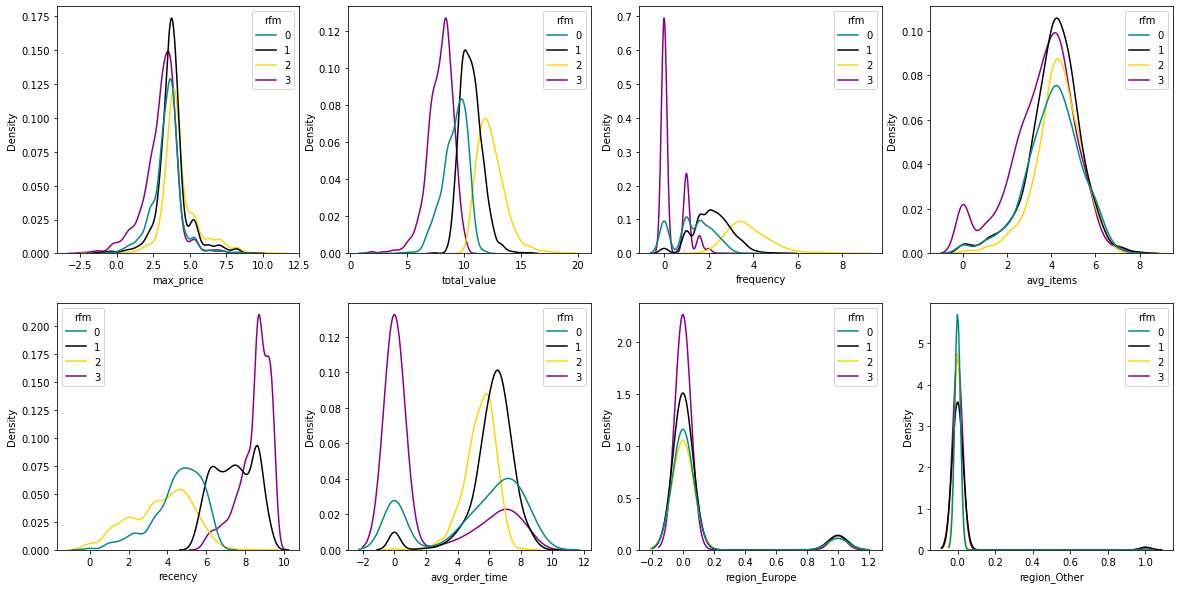

In [32]:
labeled_df['rfm'] = rfm_km_labels.values

plt.figure(figsize=(20, 10))
n=1
for col in df.columns[:8]:
    plt.subplot(2, 4, n)
    sns.kdeplot(data=labeled_df, x=col, hue='rfm', palette=colors[:4])
    n=n+1

We've already looked at some characteristics of these segments above. Recall:
- the <font color='darkcyan'>**teal**</font> segment above has low recency, low frequency, and low monetary value - these are new/growing customers; 
- the <font color='gold'>**yellow**</font> segment has low recency, high frequency, and high value - these are the current loyal customers;
- the **black** group are the high-value lapsed customers we want to get back;
- and the <font color='darkmagenta'>**purple**</font> group are the older customers who only bought once or a few times, then quickly churned.

There is some interesting insight to be taken from the avg order time plot. The purple group, as we said, mostly consists of low-frequency customers, but of the customers in this segment who made multiple orders, most waited over 3 months between orders. A very similar pattern is seen in the teal group, though this group contains fewer customers with only one order. Perhaps one thing to focus on is trying to get new customers (like the teal group) to spend less time between purchases in order to lead them to become loyal customers (yellow), perhaps reminding them or offering return discounts around 1-2 months after their previous purchase.

### 6-Cluster Model

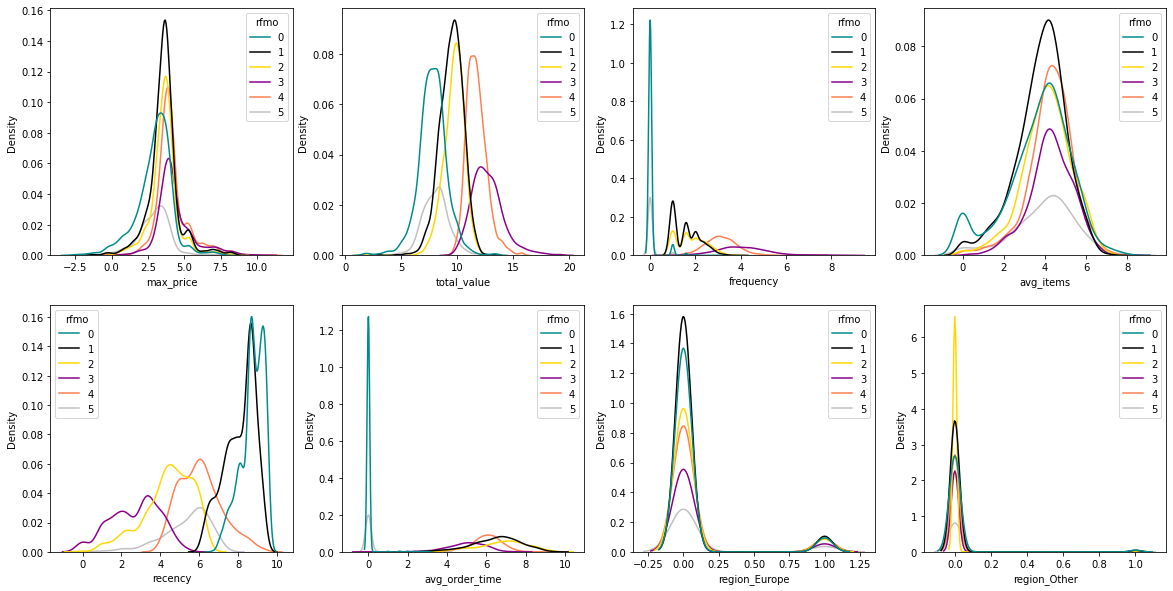

In [33]:
labeled_df['rfmo'] = rfmo_labels.values

plt.figure(figsize=(20, 10))
n=1
for col in df.columns[:8]:
    plt.subplot(2, 4, n)
    sns.kdeplot(data=labeled_df, x=col, hue='rfmo', palette=colors[:6])
    n=n+1

We can see the teal and silver segments (0 and 5) are the 1-time purchasers, like segment 1 in the 3-cluster model. However, this model is able to split that group by recency, with teal the older customers and silver the more recent customers who may be more likely to be convinced to purchase again.

Of the other 4 clusters, segment 3 (purple) has the lowest recency and highest total value. These are great repeat customers, who order frequently (both in terms of # of orders and time between orders). The pink and yellow groups are next in recency, and although the pink group has greater recency (older orders), the customers in that segments order more frequently and have a higher value than the yellow group. Special attention should be paid to the pink group, as we don't want to lose these repeat customers. The yellow group is probably made up of newer customers that have only a few orders so far, and should also be nurtured into becoming loyal customers.

**For further observations and conclusions, see the Final Report**

In [34]:
# Save the labeled log_customer data for future use
labeled_df.to_csv('final_labeled.csv')